In [ ]:
"""
!pip install torch==1.4.0 torchvision==0.5.0
!pip install gym
!pip install gym[atari]
"""

In [ ]:
"""
from google.colab import drive
drive.mount('/content/drive/')

!cp "/content/drive/My Drive/Dissertation/preprocessing.py" .
!cp -r "/content/drive/My Drive/Dissertation/gym_maze" .
!cp -r "/content/drive/My Drive/Dissertation/envs" .
"""

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

import cv2

from IPython import display
plt.ion()

# if gpu is to be used
device = torch.device("cpu")

In [2]:
env = gym.make('CartPole-v1')

---
### Helper functions

In [ ]:
def save_model(epoch, model):
    model_save_name = 'hdqn_cartpole.pt'
    path = f"{model_save_name}" 

    torch.save({
        'steps': epoch,
        'meta_controller_state_dict': model.meta_controller.state_dict(),
        'controller_state_dict': model.controller.state_dict(),
        'meta_controller_optimizer': model.meta_controller_optimizer.state_dict(),
        'controller_optimizer': model.controller_optimizer.state_dict(),
        'meta_controller_memory': model.meta_controller.memory,
        'controller_memory': model.controller.memory,
        'episode_durations': episode_durations
    }, path)

def load_model(model):
    model_save_name = 'hdqn_cartpole.pt'
    path = f"{model_save_name}" 
    checkpoint = torch.load(path)

    model.meta_controller.load_state_dict(checkpoint['meta_controller_state_dict'])
    model.controller.load_state_dict(checkpoint['controller_state_dict'])
    model.meta_controller_optimizer.load_state_dict(checkpoint['meta_controller_optimizer'])
    model.controller_optimizer.load_state_dict(checkpoint['controller_optimizer'])
    model.meta_controller.memory = checkpoint['meta_controller_memory']
    model.controller.memory = checkpoint['controller_memory']

    # model.eval() for evaluation instead
    model.train()
    return checkpoint['steps'], checkpoint['episode_durations']

In [3]:
def plot_durations():
    fig, axs = plt.subplots(2, figsize=(10,10))
    
    durations_t, durations = list(map(list, zip(*episode_durations)))
    durations = torch.tensor(durations, dtype=torch.float)
    visits_t = [(x[0], torch.tensor(x[1], dtype=torch.float)) for x in state_visits.items()]
    
    fig.suptitle('Training')
    axs[0].set_xlabel('Episode')
    axs[0].set_ylabel('Reward')
    axs[1].set_xlabel('Episode')
    axs[1].set_ylabel('State Visits')
    
    axs[0].plot(durations_t, durations.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 10:
        means = durations.unfold(0, 10, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(9), means))
        axs[0].plot(durations_t, means.numpy())
    
    if len(durations_t) >= 10:
        for t in visits_t:
            means = t[1].unfold(0, 10, 1).mean(1).view(-1)
            means = torch.cat((torch.zeros(9), means))
            axs[1].plot(means.numpy(), label=f"State {t[0]}")
            axs[1].legend()
        
    plt.pause(0.001)  # pause a bit so that plots are updated
    display.clear_output(wait=True)

---
### Code

In [4]:
# (state, action) -> (next_state, reward, done)
transition = namedtuple('transition', ('state', 'action', 'next_state', 'reward', 'done'))

# replay memory D with capacity N
class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    # implemented as a cyclical queue
    def store(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        
        self.memory[self.position] = transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [46]:
BATCH_SIZE = 16
GAMMA = 0.95

def one_hot(n, v):
    a = np.zeros(n)
    a[v] = 1.0
    return np.expand_dims(a, axis=0)

def rev_one_hot(a):
    return np.where(a[0] > 0)[0][0]

class DQN(nn.Module):
    def __init__(self, inputs, outputs, mem_len = 10000):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(inputs, 128)
        self.fc2 = nn.Linear(128, 128)
        self.head = nn.Linear(128, outputs)
        
        self.memory = ReplayMemory(mem_len)

        self.n_actions = outputs
        self.steps_done = 0
        
        self.EPS_START = 1.0
        self.EPS_END = 0.1
        self.EPS_DECAY = 1000 # in number of steps

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.head(x)
    
    def act(self, state):
        eps_threshold = self.EPS_END + (self.EPS_START - self.EPS_END) * (1. - min(1., self.steps_done / self.EPS_DECAY))
        self.steps_done += 1

        # With probability eps select a random action
        if random.random() < eps_threshold:
            return torch.tensor([[random.randrange(self.n_actions)]], device=device, dtype=torch.long)

        # otherwise select action = maxa Q∗(φ(st), a; θ)
        with torch.no_grad():
            return self(state).max(1)[1].view(1, 1)
    
    def experience_replay(self, optimizer, target):
        if len(self.memory) < BATCH_SIZE:
            return
        
        # in the form (state, action) -> (next_state, reward, done)
        transitions = self.memory.sample(BATCH_SIZE)
        batch = transition(*zip(*transitions))
        
        state_batch = torch.cat(batch.state)
        next_state_batch = torch.cat(batch.next_state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        done_mask = np.array(batch.done)
        not_done_mask = torch.from_numpy(1 - done_mask).float().to(device)
        
        current_Q_values = self(state_batch).gather(1, action_batch)
        # Compute next Q value based on which goal gives max Q values
        # Detach variable from the current graph since we don't want gradients for next Q to propagated
        next_max_q = target(next_state_batch).detach().max(1)[0]
        next_Q_values = not_done_mask * next_max_q
        # Compute the target of the current Q values
        target_Q_values = reward_batch + (GAMMA * next_Q_values)
        # Compute Bellman error (using Huber loss)
        loss = F.smooth_l1_loss(current_Q_values, target_Q_values.unsqueeze(1))
        
        # Optimize the model
        optimizer.zero_grad()
        loss.backward()
        for param in self.parameters():
            param.grad.data.clamp_(-1, 1)
        optimizer.step()
        
class HDQN(nn.Module):
    def __init__(self, inputs, outputs):
        super(HDQN, self).__init__()
        # Optimizer
        learning_rate = 2.5e-4
        
        # goal is left/right
        self.meta_controller = DQN(inputs, 2, mem_len = 100000).to(device)
        self.meta_controller_optimizer = optim.RMSprop(self.meta_controller.parameters(), lr=learning_rate)
        self.meta_controller_target = DQN(inputs, 2, mem_len = 0).to(device)
        self.meta_controller_target.eval()
        
        # takes goal+state jointly
        self.controller = DQN(inputs + 2, outputs, mem_len = 100000).to(device)
        self.controller_optimizer = optim.RMSprop(self.controller.parameters(), lr=learning_rate)
        self.controller_target = DQN(inputs + 2, outputs, mem_len = 0).to(device)
        self.controller_target.eval()
    
    def store_controller(self, *args):
        self.controller.memory.store(*args)
    
    def store_meta_controller(self, *args):
        self.meta_controller.memory.store(*args)
    
    def select_goal(self, external_observation):
        return self.meta_controller.act(external_observation)
        
    def select_action(self, joint_goal_obs):
        return self.controller.act(joint_goal_obs)
    
    def experience_replay(self):
        self.meta_controller.experience_replay(self.meta_controller_optimizer, self.meta_controller_target)
        self.controller.experience_replay(self.controller_optimizer, self.controller_target)

Complete


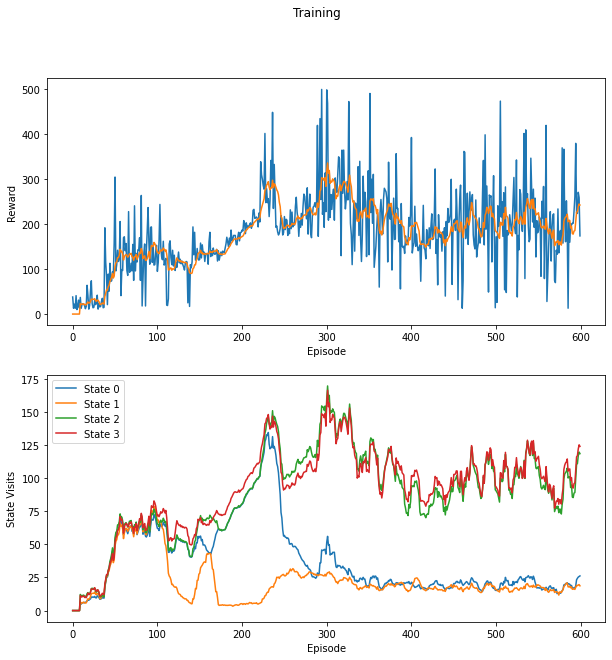

In [65]:
# Get number of actions and observations from gym action space
n_actions = env.action_space.n
n_observations = env.observation_space.shape[0]

# Initialize action-value function Q with random weights
hdqnAgent = HDQN(n_observations, n_actions).to(device)

num_episodes = 600 # M
episode_durations = []
state_visits = {0: [], 1: [], 2: [], 3: []}

steps = 0

#steps, episode_durations = load_model(hdqnAgent)
#hdqnAgent.meta_controller_target.load_state_dict(hdqnAgent.meta_controller.state_dict())
#hdqnAgent.controller_target.load_state_dict(hdqnAgent.controller.state_dict())

last_saved = steps
for i_episode in range(num_episodes):
    observation = env.reset()
    
    state = torch.from_numpy(observation).float().unsqueeze(0).to(device)

    overall_reward = 0
    ep_state_visits = {0: 0, 1: 0, 2: 0, 3: 0}
    done = False
    while not done:
        # select a goal
        goal = hdqnAgent.select_goal(state)
        goal_i = goal.item()
        encoded_goal = torch.from_numpy(one_hot(2, goal)).float().to(device)

        goal_done = False
        total_extrinsic = 0
        s_0 = state
        while not done and not goal_done:
            joint_goal_state = torch.cat([encoded_goal, state], axis=1)

            # Execute action a_t in emulator and observe reward r_t and image x_{t+1}
            action = hdqnAgent.select_action(joint_goal_state)
            action_i = action.item()

            observation, reward, done, _ = env.step(action_i)
            steps += 1
            extrinsic_reward = torch.tensor([reward], device=device)

            overall_reward += reward
            total_extrinsic += reward

            # preprocess φ_{t+1} = φ(s_{t+1})
            next_state = torch.from_numpy(observation).float().unsqueeze(0).to(device)
            joint_next_state = torch.cat([encoded_goal, next_state], axis=1)

            goal_done = (goal_i == action_i)
            
            if goal_done:
                ep_state_visits[goal_i] += 1
            ep_state_visits[action_i + 2] += 1
            
            intrinsic_reward = torch.tensor([1.0 if goal_done else 0.0], device=device)

            # Store transition (φt, at, rt, φt+1) in D
            hdqnAgent.store_controller(joint_goal_state, action, joint_next_state, intrinsic_reward, done)
            
            state = next_state

            hdqnAgent.experience_replay()

        # Store transition for meta controller
        hdqnAgent.store_meta_controller(s_0, goal, next_state, torch.tensor([total_extrinsic], device=device), done)
        hdqnAgent.experience_replay()

        #if (steps - last_saved) > 1000:
        #    last_saved = steps
        #    save_model(steps, hdqnAgent)
        
    if i_episode % 20 == 0:
        hdqnAgent.meta_controller_target.load_state_dict(hdqnAgent.meta_controller.state_dict())
        hdqnAgent.controller_target.load_state_dict(hdqnAgent.controller.state_dict())

    episode_durations.append((i_episode, overall_reward))
    for i in ep_state_visits.keys():
        state_visits[i].append(ep_state_visits[i])
    plot_durations()

print('Complete')
plot_durations()

Complete


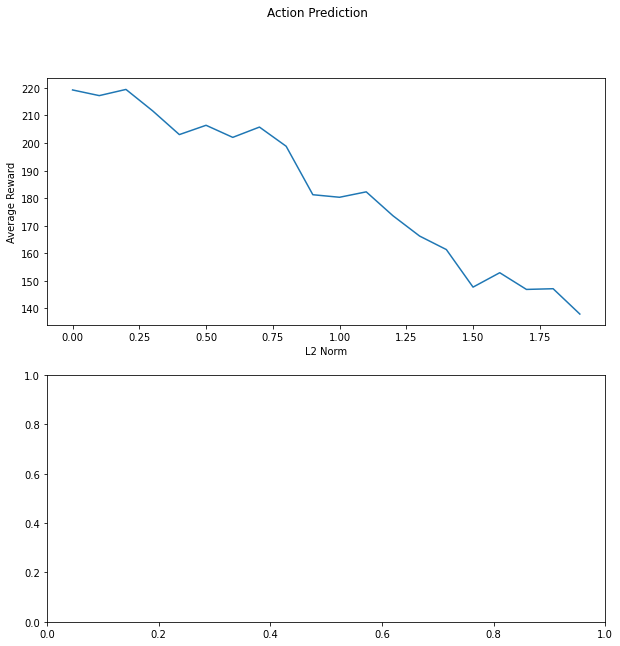

In [66]:
hdqnAgent.eval()
hdqnAgent.meta_controller.eval()
hdqnAgent.controller.eval()

episode_durations = []

num_episodes = 500

def plot_norms():
    fig, axs = plt.subplots(2, figsize=(10,10))
    
    durations_t, durations = list(map(list, zip(*episode_durations)))
    
    fig.suptitle('Action Prediction')
    axs[0].set_xlabel('L2 Norm')
    axs[0].set_ylabel('Average Reward')
    
    axs[0].plot(durations_t, durations)
        
    plt.pause(0.001)  # pause a bit so that plots are updated
    display.clear_output(wait=True)

for l2norm in range(20):
    
    overall_reward = 0
    for i_episode in range(num_episodes):
        observation = env.reset()

        state = torch.from_numpy(observation).float().unsqueeze(0).to(device)
        state = state * (np.ones(4) + (l2norm/10)*(np.random.random(4) - 0.5))
        state = state.float()
        
        done = False
        while not done:
            # select a goal
            goal = hdqnAgent.select_goal(state)
            goal_i = goal.item()
            encoded_goal = torch.from_numpy(one_hot(2, goal)).float().to(device)

            goal_done = False
            while not done and not goal_done:
                joint_goal_state = torch.cat([encoded_goal, state], axis=1)

                action = hdqnAgent.select_action(joint_goal_state)
                action_i = action.item()
                observation, reward, done, _ = env.step(action_i)

                overall_reward += reward
                
                goal_done = (goal_i == action_i)

                state = torch.from_numpy(observation).float().unsqueeze(0).to(device)
                state = state * (np.ones(4) + (l2norm/10)*(np.random.random(4) - 0.5))
                state = state.float()

    episode_durations.append((l2norm / 10, overall_reward / num_episodes))
    plot_norms()

print('Complete')
plot_norms()